In [1]:
import geopandas as gpd
import pandas as pd

## Download country MS buildings

In [ ]:
country = 'Czechia'

In [17]:
def read_ms_buildings(url):
    from shapely.geometry import shape
    df = pd.read_json(url, lines=True)
    df['geometry'] = df['geometry'].apply(shape)
    gdf = gpd.GeoDataFrame(df, crs=4326).to_crs(epsg=3035)
    return gdf

In [22]:
def read_microsoft_country_data(country):

    dataset_links = pd.read_csv("https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv")
    location_links = dataset_links[dataset_links.Location == location]

    from joblib import Parallel, delayed    
    n_jobs = -1
    all_data = Parallel(n_jobs=n_jobs)(
        delayed(read_ms_buildings)(row.Url) for _, row in location_links.iterrows()
    )

    return pd.concat(all_data, ignore_index=True)


In [23]:
%%time
gdf = read_microsoft_country_data(country)

CPU times: user 2.58 s, sys: 1.33 s, total: 3.91 s
Wall time: 3min 5s


In [34]:
gdf = gdf.sort_values('geometry').reset_index(drop=True)

In [40]:
%%time
gdf.to_parquet(f'../data/ms_{country.lower()}.parquet', geometry_encoding='geoarrow', write_covering_bbox=True, schema_version='1.1.0')

CPU times: user 5.83 s, sys: 724 ms, total: 6.55 s
Wall time: 6.53 s


### Read region data

In [5]:
region_name = 69300

In [6]:
regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "regions_hull.parquet"
    )

In [7]:
region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.loc[region_name].convex_hull

In [ ]:
prague_gdf = gpd.read_parquet('../data/ms_czechia.parquet', bbox=region_hull.bounds)
prague_gdf = prague_gdf.iloc[prague_gdf.sindex.query(region_hull, predicate='intersects')]
prague_gdf.shape

In [9]:
# import lonboard

In [10]:
# layer = lonboard.PolygonLayer.from_geopandas(prague_gdf)

In [11]:
# m = lonboard.Map(layer)

In [12]:
# m

## Define regions on MS data

In [92]:
import dask.dataframe as dd
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

In [93]:
gdf = gpd.read_parquet('../data/ms_czechia.parquet')

In [131]:
cents = gdf.centroid
gdf['x'], gdf['y'] = cents.x, cents.y
gdf['id'] = gdf.index.values
data = gdf[["x", "y", 'id']]

In [132]:
data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)
grid = data[["id", "x_100", "y_100"]].groupby(["x_100", "y_100"]).count().reset_index()

/tmp/ipykernel_2572923/4289293720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)
/tmp/ipykernel_2572923/4289293720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)


In [133]:
dbscan = DBSCAN(400, n_jobs=-1).fit(grid[["x_100", "y_100"]], sample_weight=grid["id"])
grid["labels"] = dbscan.labels_

In [134]:
data = pd.merge(data, grid, "left", on=["x_100", "y_100"])

In [135]:
counts = data.labels.value_counts()
data["core"] = data.labels.isin(counts[counts > 10000].index.drop(-1))

In [136]:
cores = data[data.core]

In [137]:
grid["core"] = grid.labels.isin(counts[counts > 10000].index.drop(-1))
grid_cores = grid[grid.core]
grid_cores = gpd.GeoDataFrame(
    grid_cores["labels"],
    geometry=gpd.points_from_xy(grid_cores["x_100"], grid_cores["y_100"]),
    crs=3035,
)
grid_cores_dissolved = grid_cores.dissolve("labels")

In [138]:
grid_non_cores = grid[~grid.core]
grid_non_cores = gpd.GeoDataFrame(
    grid_non_cores["labels"],
    geometry=gpd.points_from_xy(grid_non_cores["x_100"], grid_non_cores["y_100"]),
    crs=3035,
)

In [139]:
grid_non_cores_clustered = grid_non_cores[grid_non_cores.labels != -1]
grid_non_cores_outliers = grid_non_cores[grid_non_cores.labels == -1]

In [140]:
grid_non_cores_clustered_dissolved = grid_non_cores_clustered.dissolve("labels")

In [141]:
%%time
nearest = grid_cores.sindex.nearest(
    grid_non_cores_clustered_dissolved.geometry, return_all=False
)

CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.5 s


In [142]:
grid_non_cores_clustered_dissolved["nearest_core"] = grid_cores.labels.values[
    nearest[1]
]

In [143]:
%%time
nearest_outliers = grid_cores.sindex.nearest(
    grid_non_cores_outliers.geometry, return_all=False
)

CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 130 ms


In [144]:
grid_non_cores_outliers["nearest_core"] = grid_cores.labels.values[nearest_outliers[1]]

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [145]:
grid_non_cores = pd.concat(
    [
        grid_non_cores_clustered_dissolved.reset_index().explode(ignore_index=True),
        grid_non_cores_outliers,
    ],
    ignore_index=True,
)

In [146]:
grid_non_cores["x_100"] = grid_non_cores.geometry.x
grid_non_cores["y_100"] = grid_non_cores.geometry.y

In [147]:
data = pd.merge(
    data,
    grid_non_cores[["x_100", "y_100", "nearest_core"]],
    "left",
    on=["x_100", "y_100"],
)

In [148]:
data["region"] = data.labels
data.loc[~data.core, "region"] = data.loc[~data.core, "nearest_core"]

In [149]:
data = data.rename(
    columns={
        "id_x": "id",
        "id_y": "weight",
        "labels": "dbscan_cluster",
    }
)

In [150]:
data

,x,y,id,x_100,y_100,weight,dbscan_cluster,core,nearest_core,region
0,4.555524e+06,2.895213e+06,0,4555500.0,2895200.0,2,1465,False,1395.0,1395
1,4.555513e+06,2.895226e+06,1,4555500.0,2895200.0,2,1465,False,1395.0,1395
2,4.555531e+06,2.895390e+06,2,4555500.0,2895400.0,3,1465,False,1395.0,1395
3,4.556668e+06,2.895443e+06,3,4556700.0,2895400.0,2,1553,False,1395.0,1395
4,4.556712e+06,2.895217e+06,4,4556700.0,2895200.0,1,1553,False,1395.0,1395
...,...,...,...,...,...,...,...,...,...,...
3397211,4.833569e+06,2.863265e+06,3397211,4833600.0,2863300.0,1,-1,False,9750.0,9750
3397212,4.832729e+06,2.862271e+06,3397212,4832700.0,2862300.0,1,-1,False,9750.0,9750
3397213,4.833350e+06,2.861897e+06,3397213,4833400.0,2861900.0,1,-1,False,9750.0,9750
3397214,4.833168e+06,2.861214e+06,3397214,4833200.0,2861200.0,1,-1,False,9750.0,9750


In [152]:
pd.concat(
    [
        grid_cores,
        grid_non_cores[["nearest_core", "geometry"]].rename(
            columns={"nearest_core": "labels"}
        ),
    ]
).dissolve("labels").convex_hull.to_frame("convex_hull").to_parquet(
    "../data/ms_czechia_regions_hull.parquet"
) 

----

## Processing

In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
region_name = 4182

In [10]:
buildings_dir = '../data/ms_buildings/'
streets_dir = '../data/ms_buildings/'
enclosures_dir = '../data/ms_buildings/'
tessellations_dir = '../data/ms_buildings/'
graph_dir = '../data/ms_buildings/'
chars_dir = '../data/ms_buildings/chars/'

In [4]:
region_hulls = gpd.read_parquet("../data/ms_buildings/ms_czechia_regions_hull.parquet")

In [5]:
region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.loc[region_name].convex_hull

## process buildings

In [170]:
from core.generate_buildings import read_region_buildings, process_region_buildings

In [172]:
buildings = gpd.read_parquet('../data/ms_buildings/ms_czechia.parquet', bbox=region_hull.bounds)
buildings = buildings.iloc[buildings.sindex.query(region_hull, predicate='intersects')]
buildings.shape

(234287, 3)

In [173]:
buildings = process_region_buildings(buildings, True, simplification_tolerance=.1, merge_limit=25)

Percent polygons:  1.0
Final polygons:  231507 , dropped:  0.011865788541404299


In [174]:
buildings.to_parquet(buildings_dir + f"buildings_{region_id}.parquet")

## process streets

In [164]:
from core.generate_streets import process_region_streets

In [165]:
## overture is indexed based on 4326
overture_hull = region_hulls.loc[[region_name], ].to_crs(epsg=4326).convex_hull.iloc[0]

In [166]:
%%time
## processs streets
streets = process_region_streets(overture_hull, region_id)

CPU times: user 3.06 s, sys: 1.31 s, total: 4.37 s
Wall time: 2min 26s


/home/krasen/urban_taxonomy/core/generate_streets.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]


<Axes: >

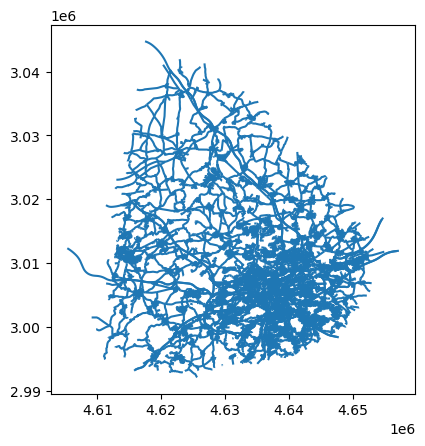

In [168]:
streets.plot()

In [169]:
## save streets
streets.to_parquet(streets_dir + f'streets_{region_id}.parquet')

## process elements

In [6]:
from core.generate_elements import process_region_elements

In [7]:
enclosures, tesselations = process_region_elements(buildings_dir, streets_dir, region_id)

---- Processing region:  4182 2024-07-20 11:28:45.153144


In [18]:
enclosures.to_parquet(enclosures_dir + f"enclosure_{region_id}.parquet")
print("Processed enclosures")

## save files
tesselations.to_parquet(
    tessellations_dir + f"tessellation_{region_id}.parquet"
)
print("processed tesselations")

Processed enclosures
processed tesselations


In [17]:
# import lonboard
# layer = lonboard.PolygonLayer.from_geopandas(tesselations, opacity=.15)
# m = lonboard.Map(layer)

## process graphs

In [24]:
process_region_graphs(
    region_id,
    graph_dir,
    buildings_dir,
    streets_dir,
    enclosures_dir,
    tessellations_dir,
)

Built tess graph knn=1
Built buildings graph knn=1
Built streets graph knn=1
Built enclosure graph knn=1


/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 266 disconnected components.
  w = W(neighbors, weights, ids, silence_warnings=silence_warnings)


Built nodes graph knn=1


## process chars

In [6]:
from core.generate_chars import process_single_region_chars

In [7]:
process_single_region_chars(
    region_id,
    graph_dir,
    buildings_dir,
    streets_dir,
    enclosures_dir,
    tessellations_dir,
    chars_dir
)

2024-07-20 12:24:44.261120 ----Processing ------ 4182
Processing streets


/home/krasen/momepy/momepy/functional/_diversity.py:73: RuntimeWarning: invalid value encountered in cast
  ).values.astype(bool)


Processing enclosures
Processing buildings
Processing tessellation


## merge data

In [12]:
tessellation = gpd.read_parquet(chars_dir + f"tessellations_chars_{region_id}.parquet")
buildings = gpd.read_parquet(chars_dir + f"buildings_chars_{region_id}.parquet")
enclosures = gpd.read_parquet(chars_dir + f"enclosures_chars_{region_id}.parquet")
streets = gpd.read_parquet(chars_dir + f"streets_chars_{region_id}.parquet")
nodes = gpd.read_parquet(chars_dir + f"nodes_chars_{region_id}.parquet")

merged = pd.merge(
    tessellation.drop(columns=["geometry"]),
    buildings.drop(columns=["nodeID", "geometry", 'nID']),
    right_index=True,
    left_index=True,
    how="left",
)

merged = merged.merge(
    enclosures.drop(columns="geometry"),
    right_on="eID",
    left_on="enclosure_index",
    how="left",
)

merged = merged.merge(streets.drop(columns="geometry"), on="nID", how="left")
merged = merged.merge(nodes.drop(columns="geometry"), on="nodeID", how="left")

merged = merged.drop(
    columns=[
        "nID",
        "eID",
        "nodeID",
        "mm_len",
        "cdsbool",
        "node_start",
        "node_end",
        "x",
        "y",
        "enclosure_index",
        # "id",
        # "osm_id",
    ]
)
merged = merged.set_index(tessellation.index)

from core.utils import used_keys
primary = merged[list(used_keys.keys())]
primary.to_parquet(chars_dir + f'primary_chars_{region_id}.parquet')